In [1]:
import numpy as np
import torch
# import os
import gzip
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
# from torchvision import datasets
# from torchvision.transforms import ToTensor

# my project
from module.conf import PROJECT_DIR

# matplotlib.use("QTAgg")
%matplotlib inline

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')
    # torch.cuda.is_available()
    # torch.cuda.device_count()
    # torch.cuda.current_device()
    # torch.cuda.device(0)
    # torch.cuda.get_device_name(0)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using device: cpu
Using mps device


Each training and test example is assigned to one of the following labels:
|Label|Description|
|-|-----|
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle boot|

In [3]:
M_LABEL = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
           5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [4]:
def load_data(kind: str) -> tuple[np.ndarray, np.ndarray]:
    fashion_mnist_path = "/data/sample/fashion_mnist"
    images_path = "".join([PROJECT_DIR, fashion_mnist_path, f"/{kind}-images-idx3-ubyte.gz"])
    labels_path = "".join([PROJECT_DIR, fashion_mnist_path, f"/{kind}-labels-idx1-ubyte.gz"])
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28)

    return images, labels

In [5]:
X_train, Y_train = load_data(kind='train')
X_test, Y_test = load_data(kind='t10k')

In [6]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", Y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", Y_test.shape)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


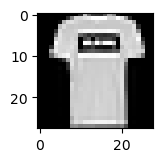

Y_train[1]:0: T-shirt/top


In [7]:
ind = 1
fig, ax = plt.subplots(figsize=(1.5, 1.5))
ax.imshow(X=X_train[ind], cmap="gray")
plt.show()
print(f"Y_train[{ind}]:{Y_train[ind]}: {M_LABEL[Y_train[ind]]}")

### 1. PyTorch

#### 1.1. Define model:

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=10)
        )
        return

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


#### 1.2. Define Train and Test functions:

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [11]:
def train(dataloader, model, loss_fn, optimizer) -> None:
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return

In [12]:
def test(dataloader, model, loss_fn) -> None:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return

#### 1.3. Perform train:

In [16]:
epochs = 5
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).int())
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).int())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 17.550564  [   64/60000]
loss: 0.535674  [ 6464/60000]
loss: 0.405598  [12864/60000]
loss: 0.506915  [19264/60000]
loss: 0.665860  [25664/60000]
loss: 0.436906  [32064/60000]
loss: 0.417761  [38464/60000]
loss: 0.520321  [44864/60000]
loss: 0.521910  [51264/60000]
loss: 0.701504  [57664/60000]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.469908 

Epoch 2
-------------------------------
loss: 0.272528  [   64/60000]
loss: 0.395379  [ 6464/60000]
loss: 0.323927  [12864/60000]
loss: 0.441070  [19264/60000]
loss: 0.510077  [25664/60000]
loss: 0.404954  [32064/60000]
loss: 0.382366  [38464/60000]
loss: 0.560425  [44864/60000]
loss: 0.412607  [51264/60000]
loss: 0.594571  [57664/60000]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.460533 

Epoch 3
-------------------------------
loss: 0.354653  [   64/60000]
loss: 0.355628  [ 6464/60000]
loss: 0.290437  [12864/60000]
loss: 0.352606  [19264/60000]
loss: 0.419016  [25664/60000]
loss: 0.645524  [32064/60